In [14]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import math

In [16]:
df = pd.read_csv("/content/drive/MyDrive/Project(WOC)/classification_train.csv" )
Y_train = np.array(df.iloc[0:25000,1:2],dtype='int32')
X_train= np.array(df.iloc[0:25000,2:786],dtype = 'float64')
X_CVS = np.array(df.iloc[25000:30000,2:786],dtype = 'float64')
Y_CVS = np.array(df.iloc[25000:30000,1:2],dtype = 'int32')

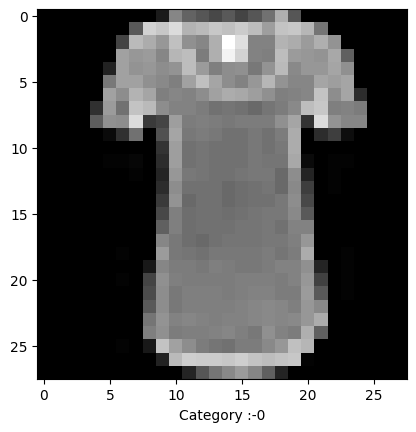

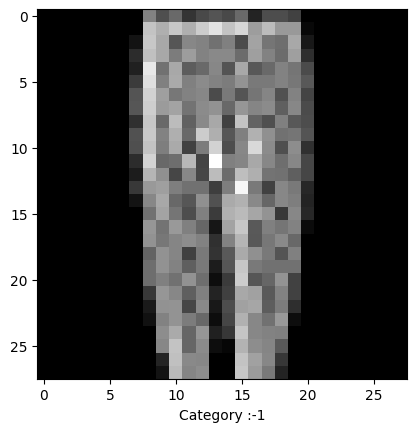

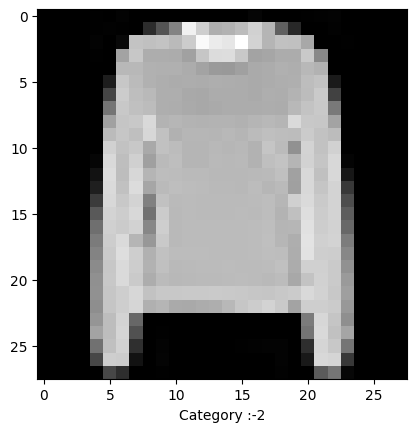

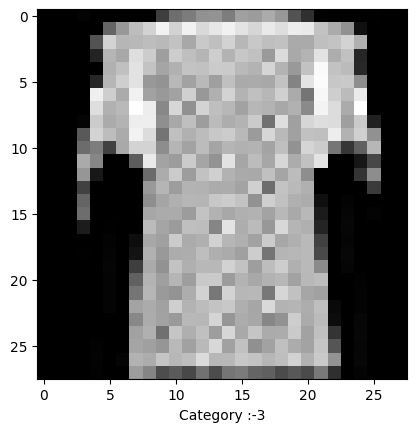

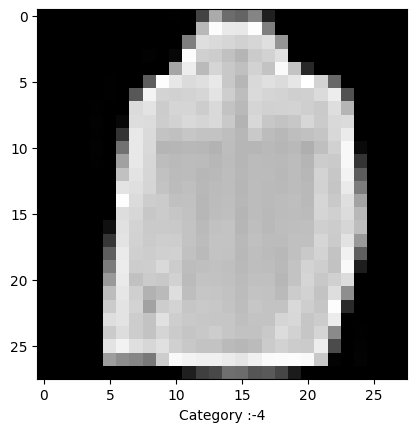

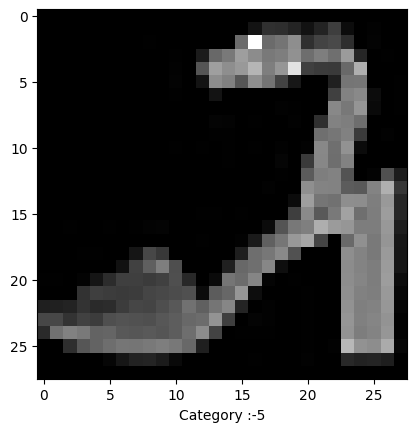

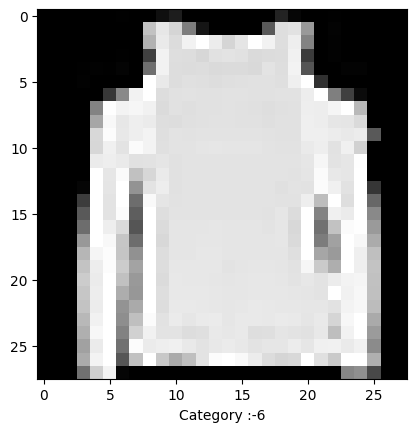

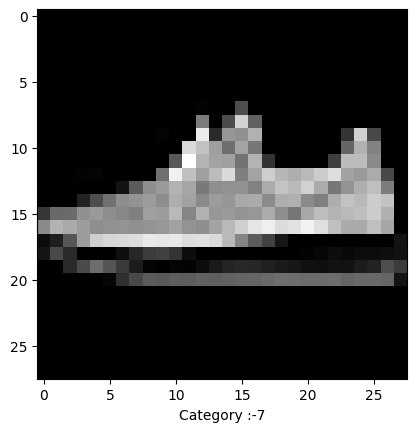

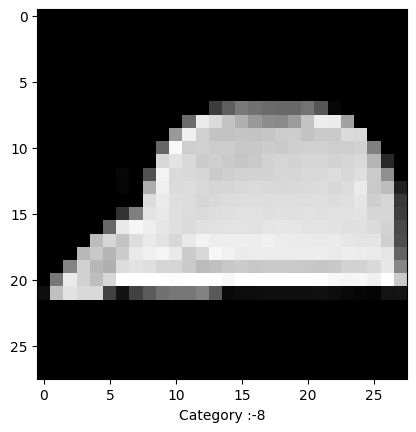

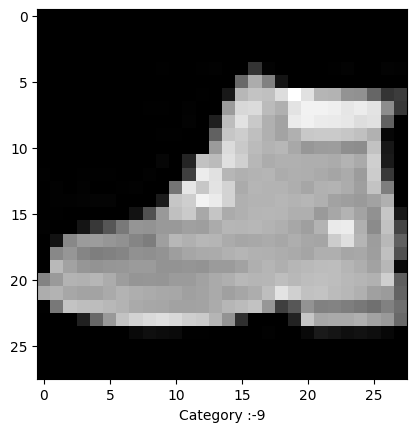

In [17]:
Categories,indexes = np.unique(Y_train,return_index = True,axis = 0)
for i in indexes:
  plt.imshow(X_train[i,:].reshape(28,28),cmap = "gray")
  plt.xlabel("Category :-" + str(Y_train[i,0]))
  plt.show()

In [18]:
J = []
iterations = []

In [19]:
df1 = pd.read_csv("/content/drive/MyDrive/Project(WOC)/classification_test.csv" )
X_test = np.array(df1.iloc[0:10000,1:785])

In [20]:
class NeuralNetwork:
  def __init__(self,layers):
    #layers contains number of neurons in evry layer including input and output layer
    self.n = len(layers)
    self.layers = layers
    self.parameters = {}
    self.V = {}
    self.S = {}
    for i in range(1,self.n):
      self.parameters["W"+str(i)] = np.random.randn(layers[i],layers[i-1])*(np.sqrt(2/layers[i-1]))
      self.parameters["B"+str(i)] = np.random.randn(layers[i],1)
      self.V["dW"+str(i)] = np.zeros((layers[i],layers[i-1]),dtype = "float128")
      self.V["db"+str(i)] = np.zeros((layers[i],1),dtype = "float128")
      self.S["dW"+str(i)] = np.zeros((layers[i],layers[i-1]),dtype = "float128")
      self.S["db"+str(i)] = np.zeros((layers[i],1),dtype = "float128")     
  def Normalization(self,X):
    self.mu = np.mean(X,axis = 0)
    self.sigma = np.std(X,axis = 0)
    return  (X-self.mu)/self.sigma
  def transform(self,Y):
    Y = Y.reshape(1,-1)
    Y_new = np.repeat(Y,10,axis = 0)
    A = np.array([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]])
    Y_new = np.where(Y==A,1,0)
    return Y_new
  def relu(self,z):
    return np.maximum(0,z)
  def softmax(self,z):
    return (1/np.sum(np.exp(z),axis =0))*(np.exp(z))
  def relu_derivative(self,Z):
    return np.where(Z>0,1,0)
  def softmax_derivative(self,A,Y):
    dz = A - Y
    return dz
  def forward_pass(self,X,lamda):
    Z = []
    A = [X]
    self.dropout = [np.ones(X.shape)]
    for i in range(1,self.n-1):
        Z.append(np.dot(self.parameters["W"+str(i)],A[i-1])+self.parameters["B"+str(i)])
        a,b = self.relu(Z[i-1]).shape[0],self.relu(Z[i-1]).shape[1]
        self.dropout.append(np.random.randn(a,b)<lamda[i])
        A.append(self.relu(Z[i-1])*self.dropout[i]/lamda[i])
    Z.append(np.dot(self.parameters["W"+str(self.n-1)],A[self.n-2])+self.parameters["B"+str(self.n-1)])
    A.append(self.softmax(Z[self.n-2]))
    forward_values = (A,Z)
    return forward_values
  def backward_pass(self,forward_values,Y,lamda):
    #Note this Y is assumed to be a transformed Y
    m = Y.shape[1]#number of training examples
    A,Z = forward_values 
    gradients = {}
    gradients["dA"+str(self.n-1)] = -(Y)*(1/A[self.n-1])
    gradients["dZ"+str(self.n -1)] = (self.softmax_derivative(A[self.n-1],Y))
    i = self.n- 1
    while (i > 1):
      gradients["dW"+str(i)] = (np.dot(gradients["dZ"+str(i)],A[i-1].transpose()))/m
      gradients["db"+str(i)] = (np.sum(gradients["dZ"+str(i)],axis = 1,keepdims = True))/m
      gradients["dA"+str(i-1)] = np.dot(self.parameters["W"+str(i)].transpose(),gradients["dZ"+str(i)])*self.dropout[i-1]/lamda[i-1]
      gradients["dZ"+str(i-1)] = (self.relu_derivative(Z[i-2]))*(gradients["dA"+str(i-1)])
      i -= 1
    gradients["dW"+str(1)] = (np.dot(gradients["dZ"+str(1)],A[0].transpose()))/m 
    gradients["db"+str(1)] = (np.sum(gradients["dZ"+str(1)],axis = 1,keepdims = True))/m
    return gradients
  def mini_batches(self,X,Y):
    m = X.shape[1]
    permutation = list(np.random.permutation(m))
    Y = Y.reshape(1,-1)
    shuffled_X = X[:,permutation]
    shuffled_Y = Y[:,permutation]
    mini_batch_size = 4096
    num_batches = math.floor(m / (mini_batch_size))
    mini_batches = []
    for i in range(num_batches):
      mini_batch_X = shuffled_X[:, i*mini_batch_size : (i+1)*mini_batch_size]
      mini_batch_Y = shuffled_Y[:, i*mini_batch_size : (i+1)*mini_batch_size]
      mini_batch = (mini_batch_X, mini_batch_Y)
      mini_batches.append(mini_batch)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_batches*mini_batch_size : X.shape[1]]
        mini_batch_Y = shuffled_Y[:, num_batches*mini_batch_size :  Y.shape[1]]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    '''Note the lack of the last if statement is used to append the last mini_batch but we don't have a else for last mini_batch 
    because if m%mini_batch_size ==0 then that appendment of batch is already included in the above for loop'''
    return mini_batches
  def fit(self,X,Y,learning_rate,epoches,lamda):
    #note lamda is the probability to keep any neurons in every layer 
    X = self.Normalization(X)
    X = X.transpose()
    self.mini_batch_gradient_descent(X,Y,learning_rate,epoches,lamda)
  def mini_batch_gradient_descent(self,X,Y,learning_rate,epoches,lamda):
    t = 0
    for i in range(epoches):
      mini_batch= self.mini_batches(X,Y)
      l = len(mini_batch)
      cost_av = 0
      for mini_batch_X,mini_batch_Y in mini_batch:
        mini_batch_Y = self.transform(mini_batch_Y)
        t = t+1
        forward_values = self.forward_pass(mini_batch_X,lamda)
        gradients = self.backward_pass(forward_values,mini_batch_Y,lamda)
        cost_av += (self.cost_function(mini_batch_Y,forward_values))/l
        for j in range(1,self.n):
          self.V["dW"+str(j)] = ((0.9)*self.V["dW"+str(j)]+(0.1)*gradients["dW"+str(j)])
          self.V["db"+str(j)] = ((0.9)*self.V["db"+str(j)]+(0.1)*gradients["db"+str(j)])
          self.S["dW"+str(j)] = ((0.999)*self.S["dW"+str(j)]+(0.001)*((gradients["dW"+str(j)])**2))
          self.S["db"+str(j)] = ((0.999)*self.S["db"+str(j)]+(0.001)*((gradients["db"+str(j)])**2))
          self.parameters["W"+str(j)] -= (learning_rate)*(self.V["dW"+str(j)])/(np.sqrt(np.abs(self.S["dW"+str(j)]))+1e-8)
          self.parameters["B"+str(j)] -= (learning_rate)*(self.V["db"+str(j)])/(np.sqrt(np.abs(self.S["db"+str(j)]))+1e-8)
      if i%50==0:
        print(f"Cost function at  {i} th iteration is :-  {cost_av}")
        J.append(cost_av)
        iterations.append(i)
  def cost_function(self,Y,forward_values):
    A,Z = forward_values
    cost = 0
    cost = np.sum(np.sum((-1)*Y*np.log(A[self.n-1]),axis = 0,keepdims = True),axis = 1)
    cost /= Y.shape[1]
    return cost
  def evaluate(self,X_test):
    X_test= (X_test-self.mu)/self.sigma
    X_test = X_test.transpose()
    a = [1.0]
    for i in range (self.n):
      a.append(1.0)
    forward_values = self.forward_pass(X_test,a)
    A,Z = forward_values
    Y = np.argmax(A[self.n-1], axis=0,keepdims = True)
    return Y    
  def CVS(self,X_check,Y_check):
    Y_pred = self.evaluate(X_check) 
    return accuracy_score(Y_check.flatten(), Y_pred.flatten())

In [ ]:
model = NeuralNetwork([X_train.shape[1],400,100,len(Categories)])
model.fit(X_train,Y_train,0.001,201,[1,0.7,1])
print(model.CVS(X_train,Y_train.reshape(1,-1)))
print(model.CVS(X_CVS,Y_CVS.reshape(1,-1)))

In [ ]:
plt.xlabel("No. of iterations")
plt.ylabel("Cost function value ")
plt.plot(iterations,J)
plt.show()

In [23]:
print(model.CVS(X_train,Y_train.reshape(1,-1)))
print(model.CVS(X_CVS,Y_CVS.reshape(1,-1)))

0.98852
0.8864


In [24]:
output = model.evaluate(X_test)
df1["output label"]=output.transpose()
a = np.array(df1.columns)
df2 = df1.drop(a[1:-1],axis = 1 )
df2
df2.to_csv('/content/drive/MyDrive/Project(WOC)/NeuralNetwork_output.csv')

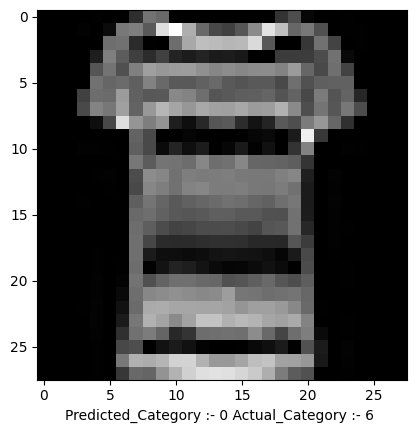

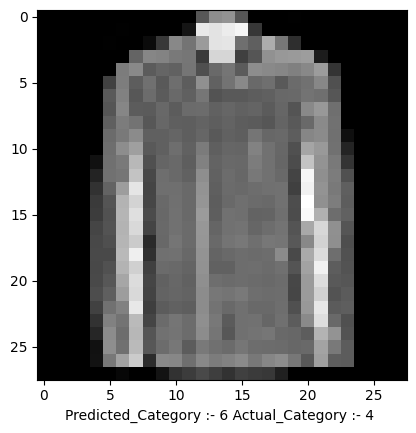

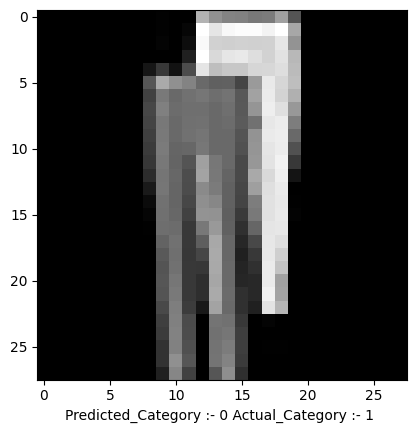

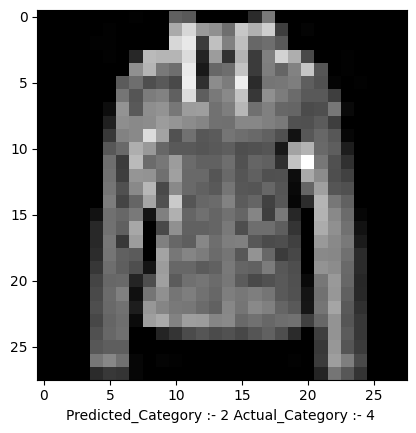

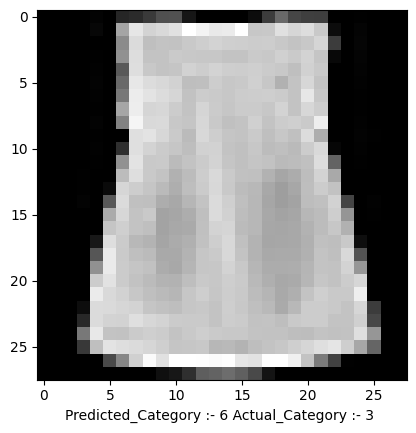

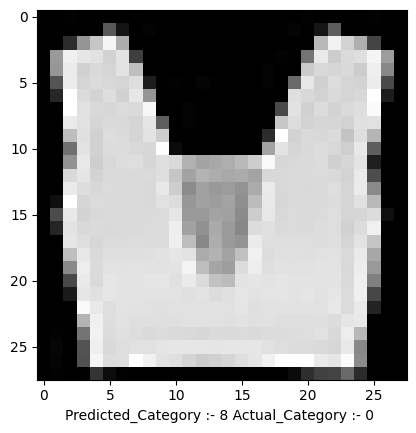

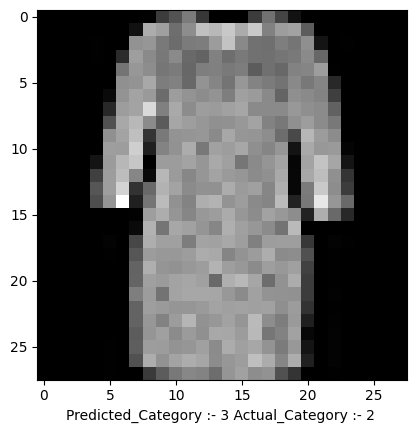

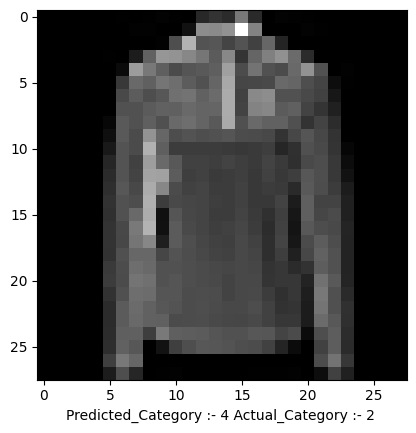

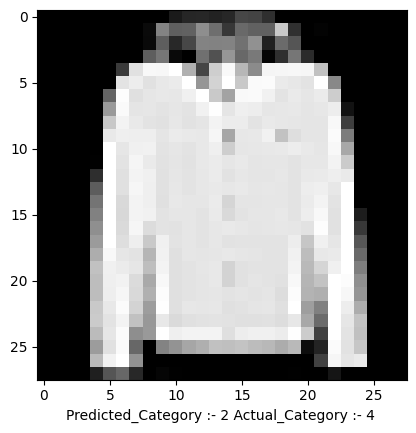

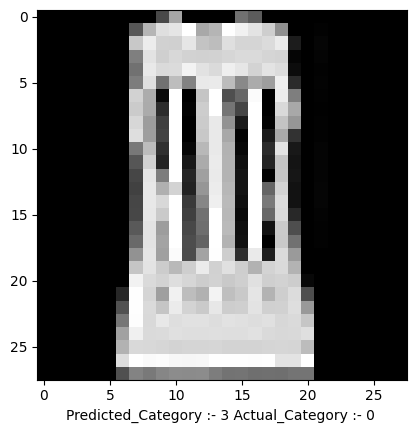

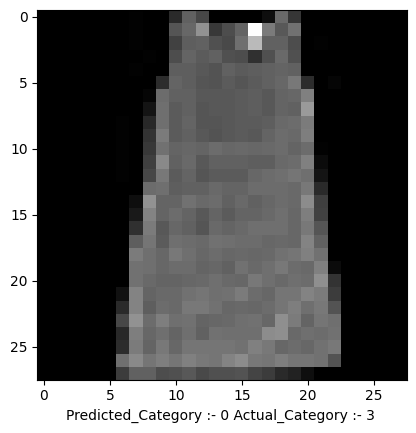

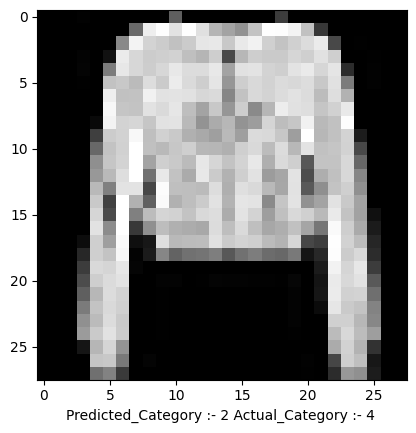

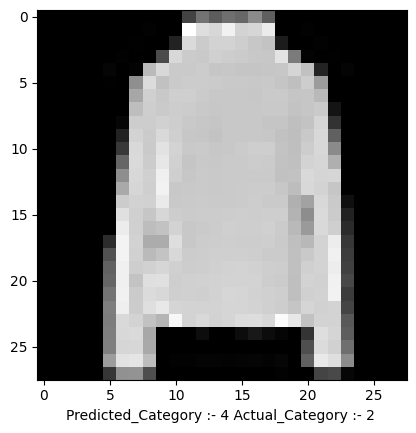

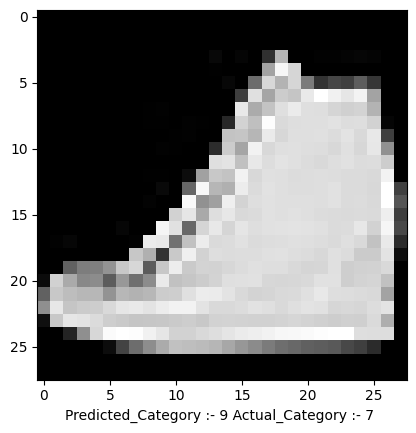

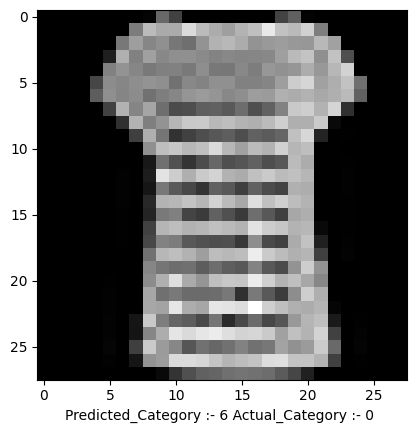

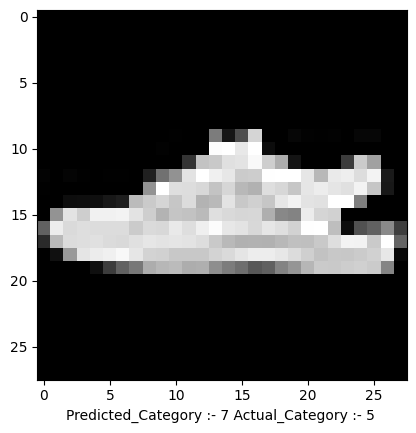

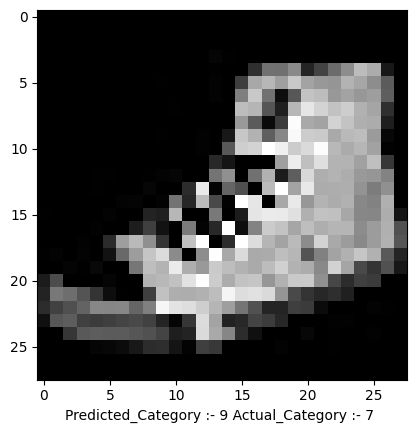

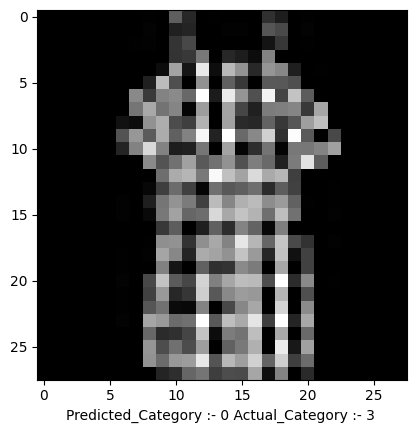

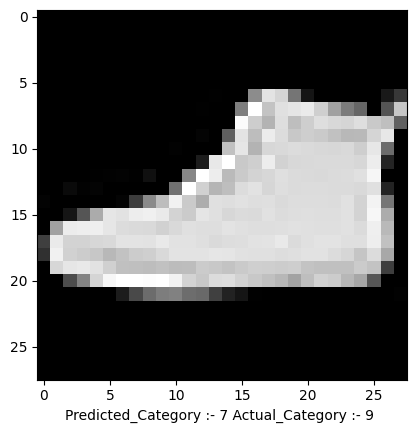

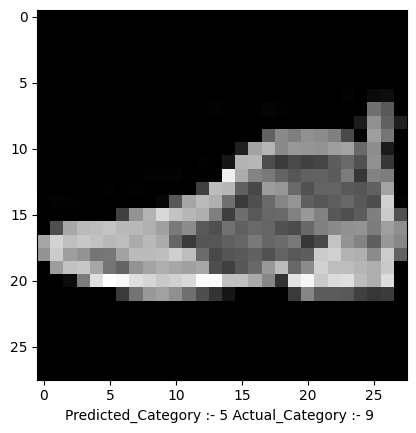

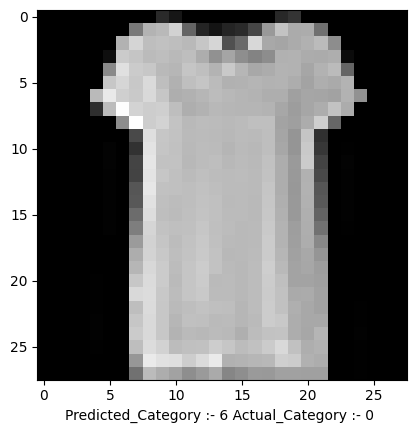

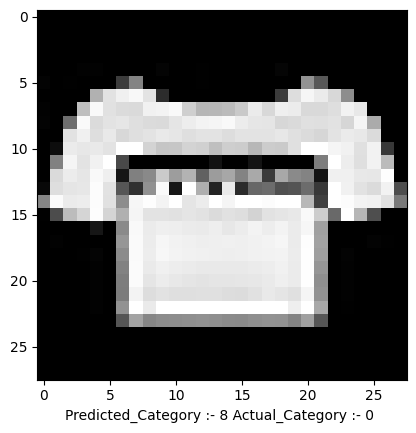

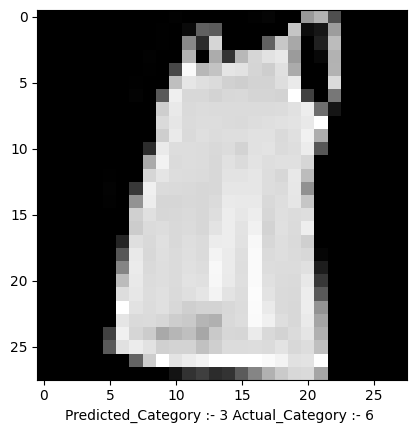

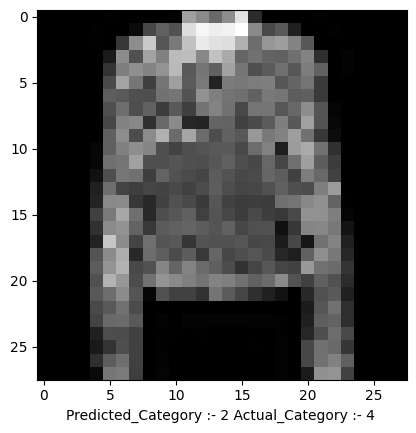

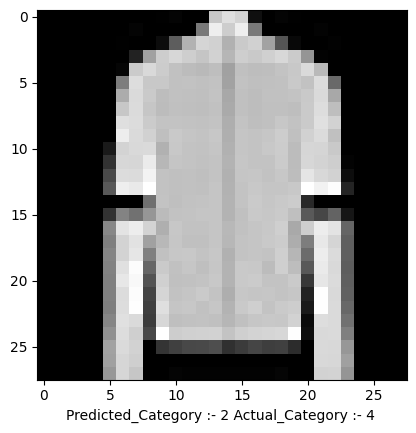

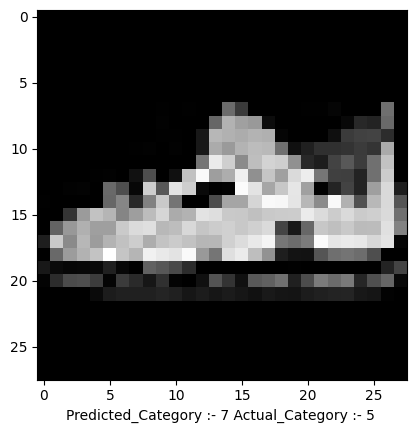

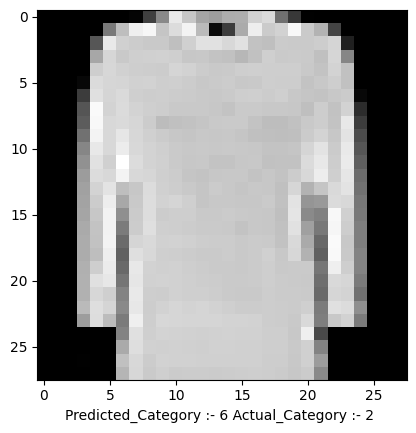

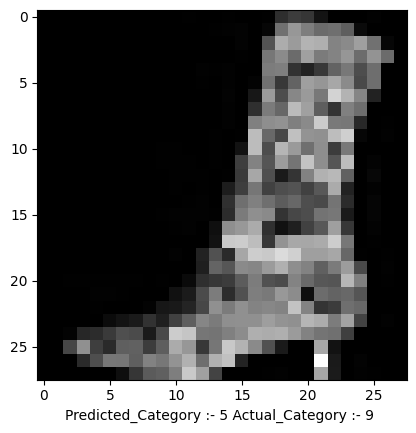

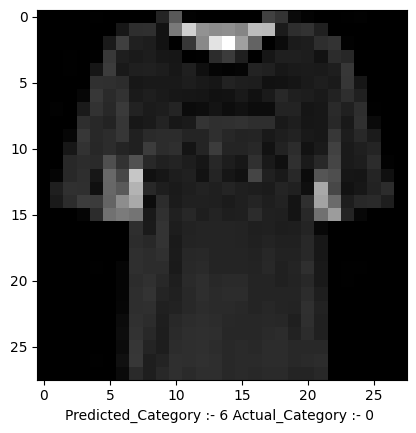

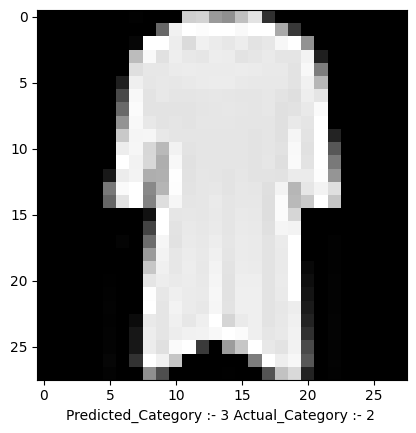

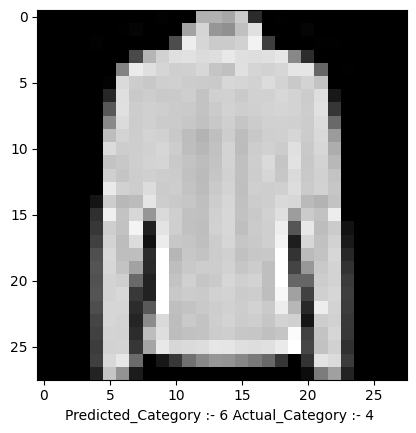

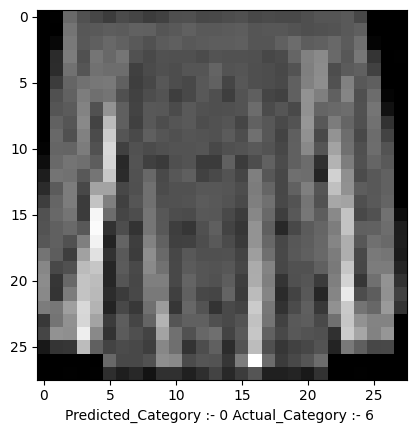

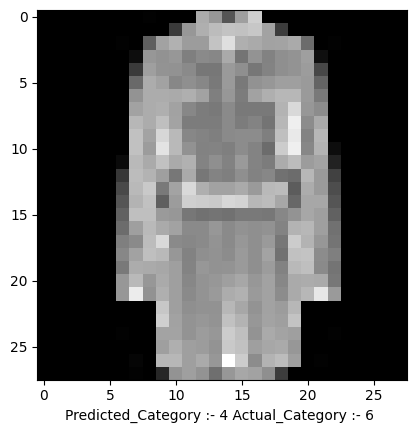

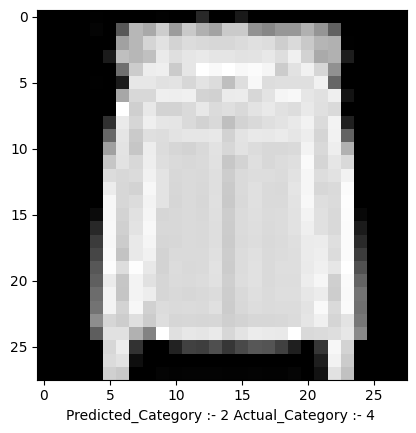

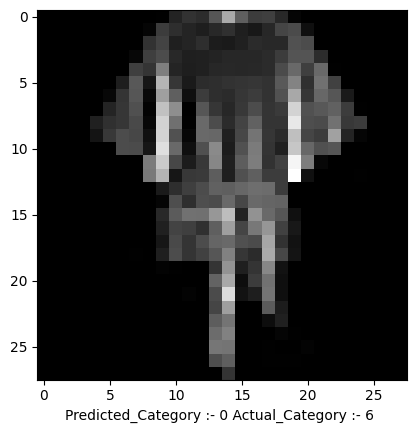

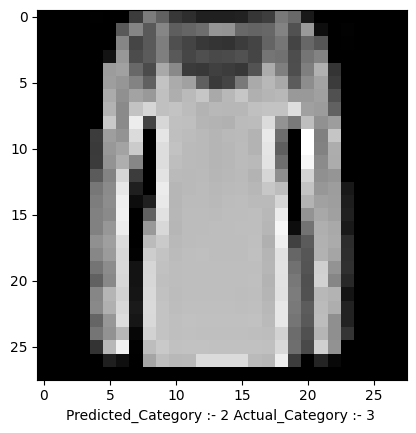

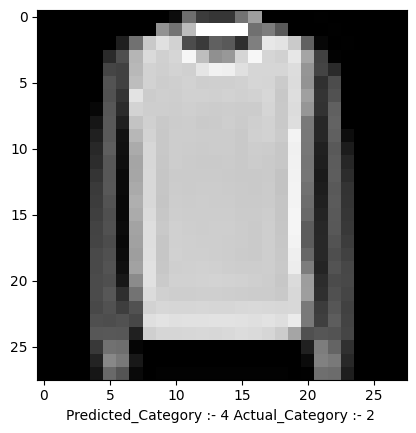

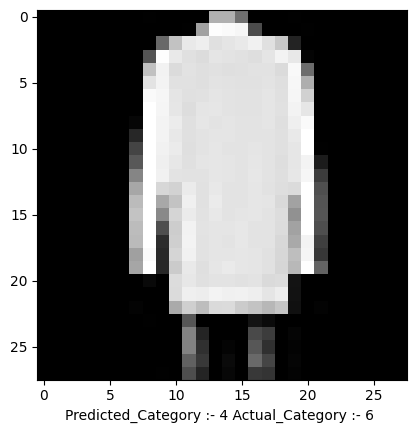

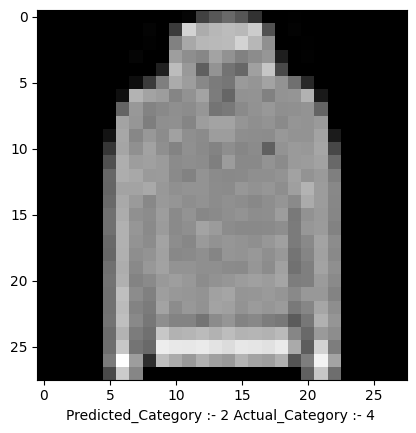

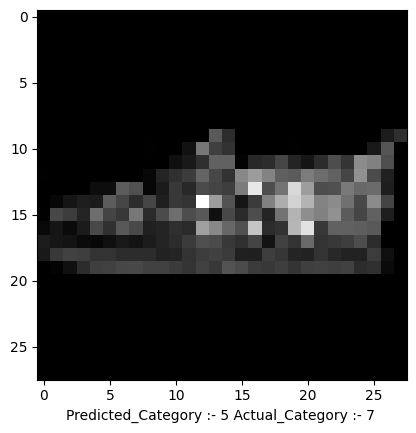

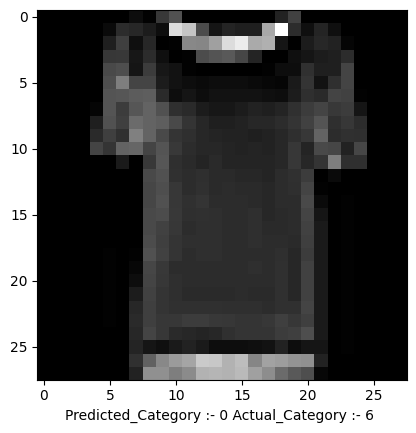

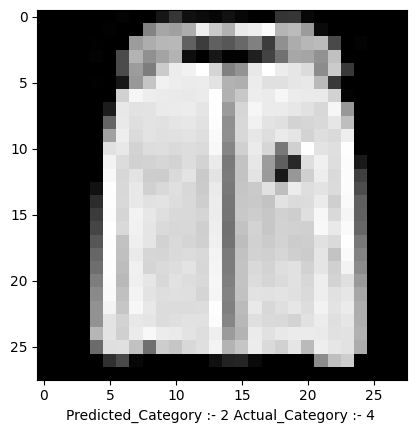

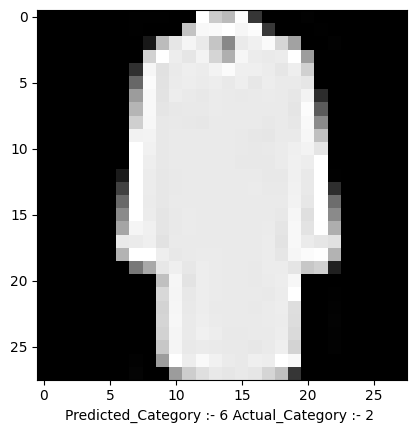

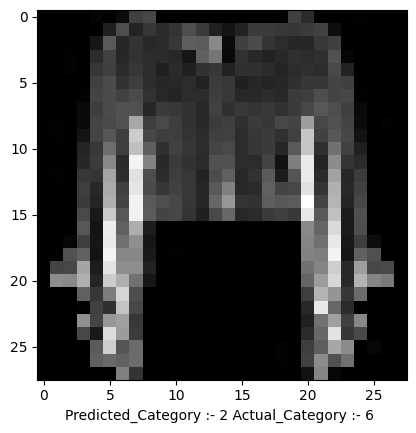

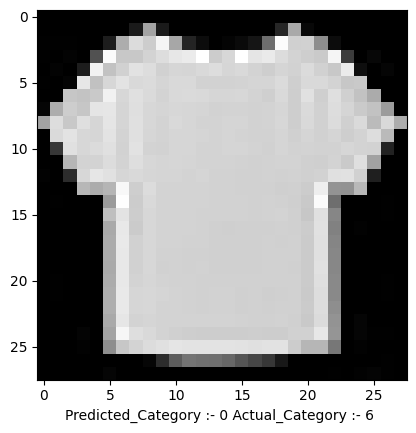

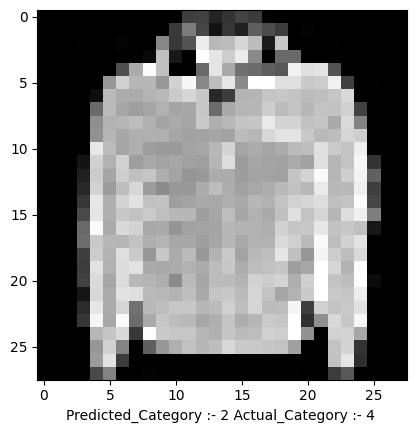

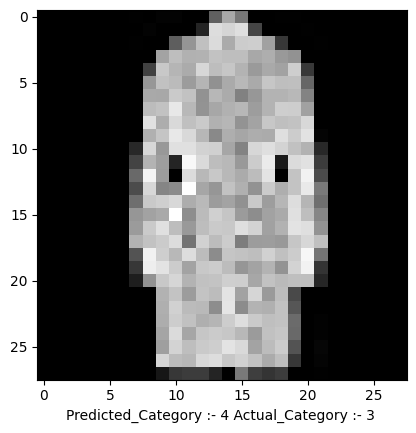

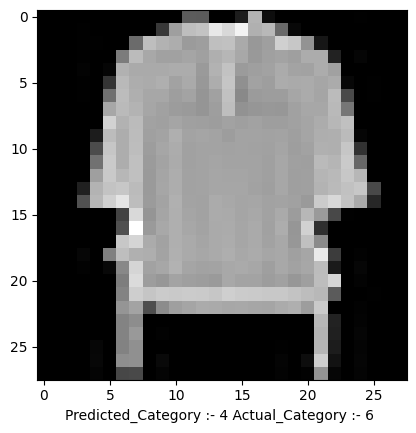

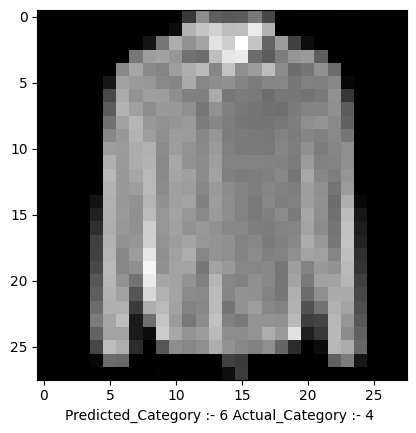

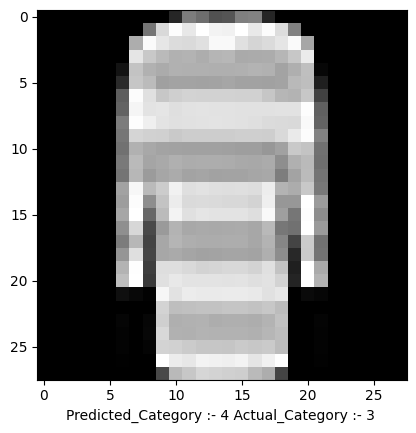

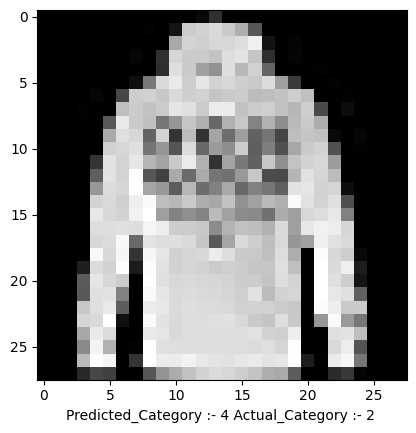

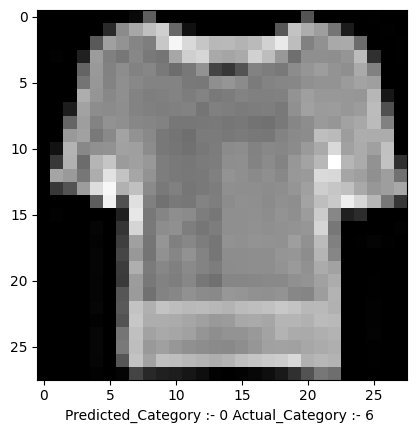

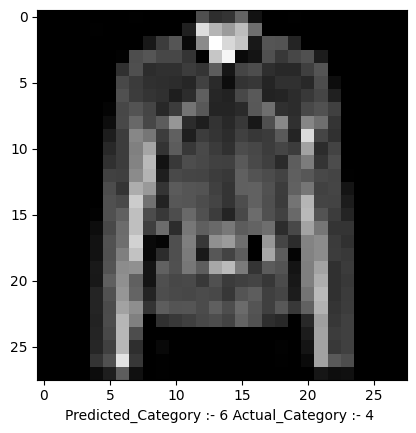

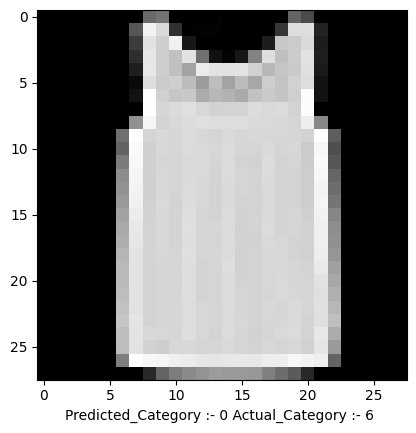

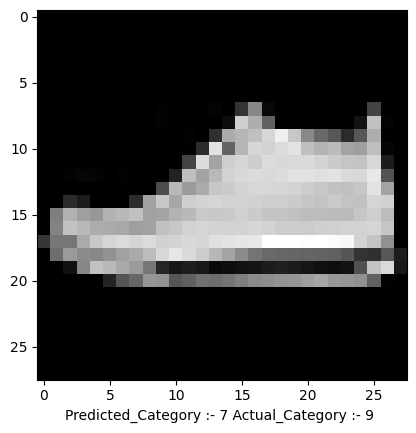

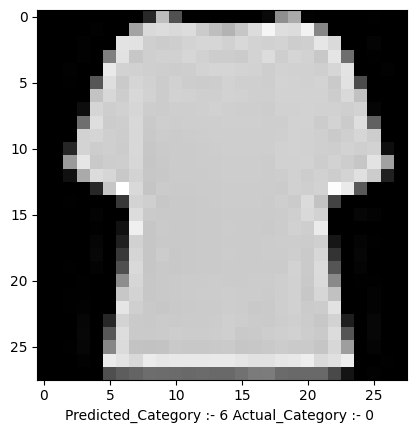

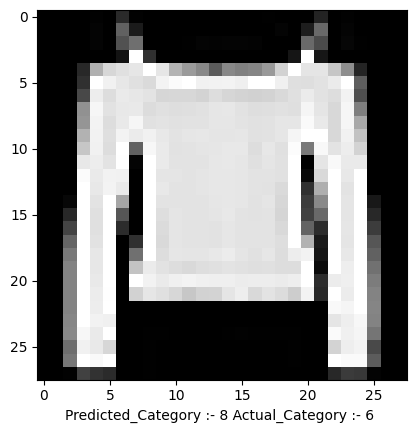

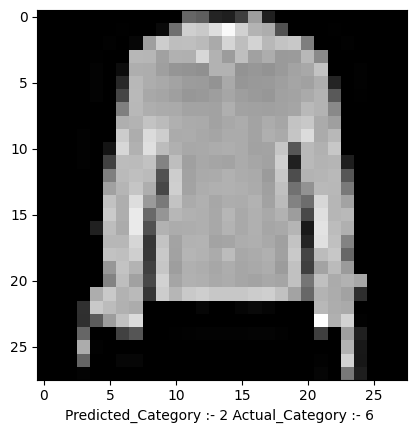

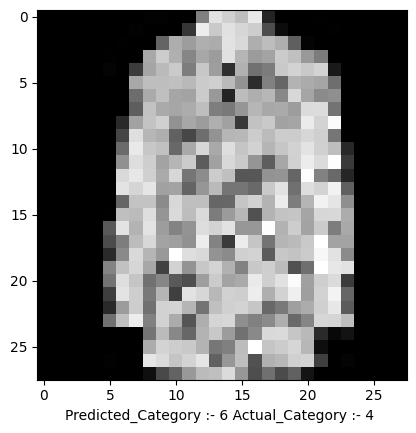

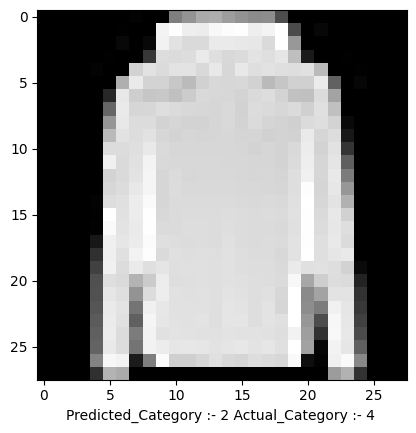

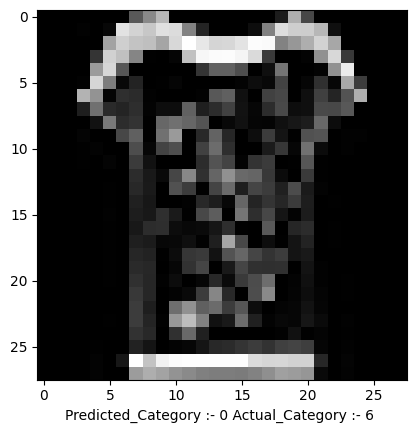

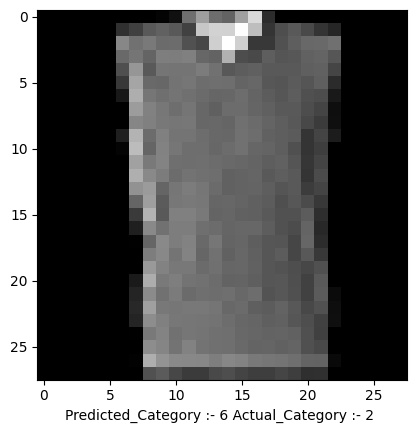

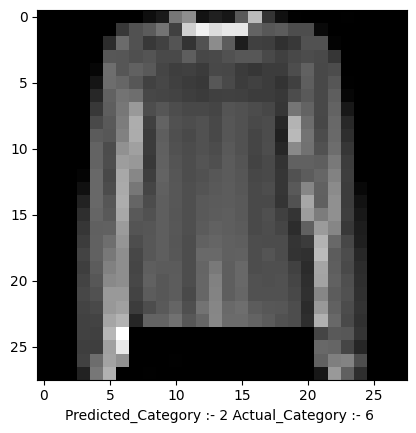

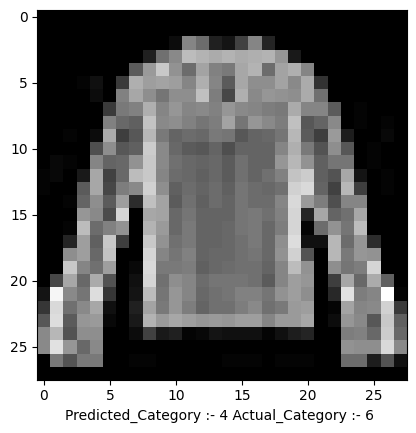

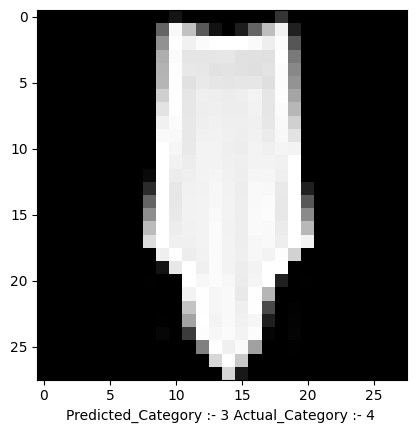

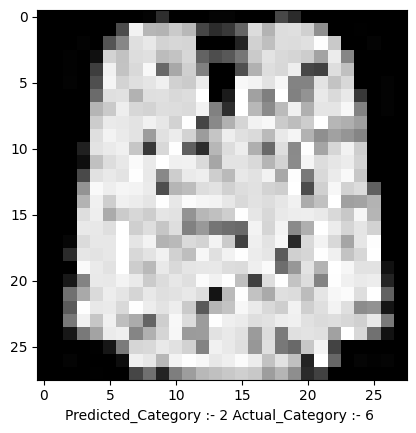

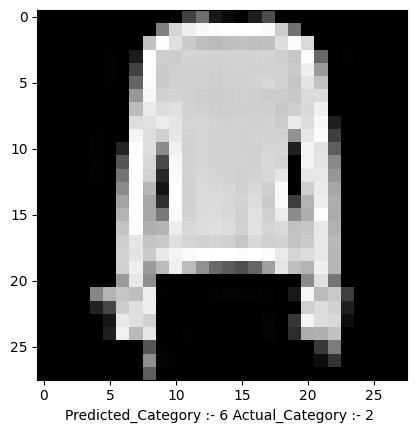

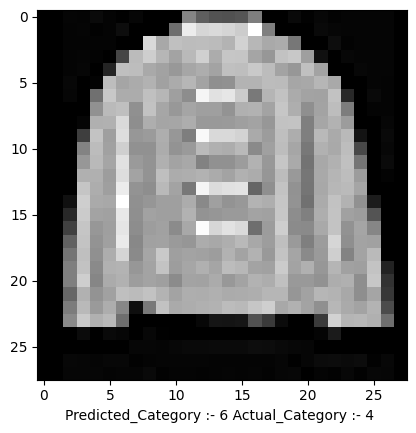

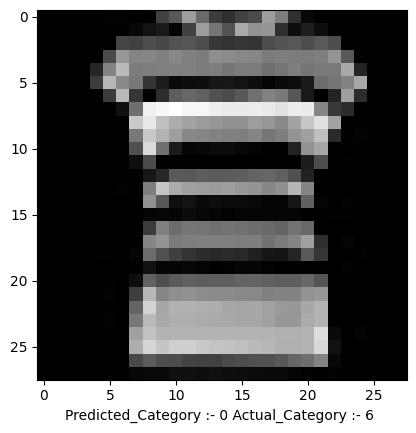

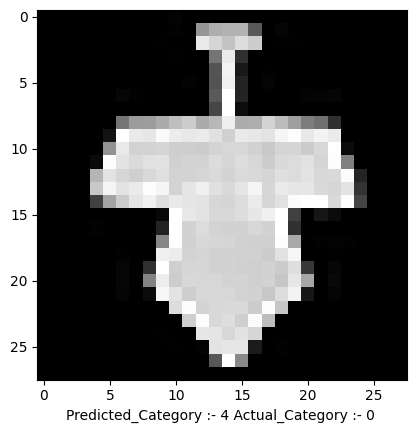

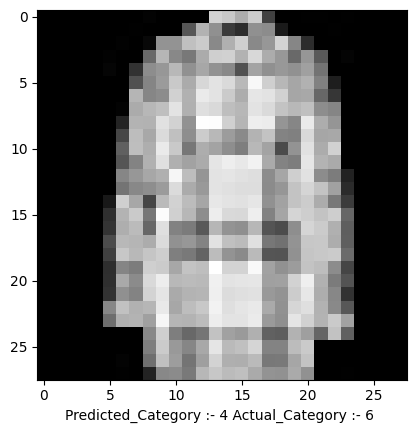

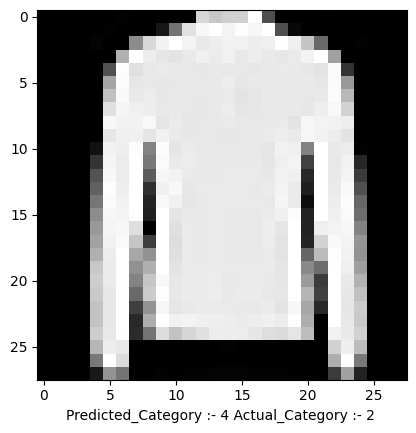

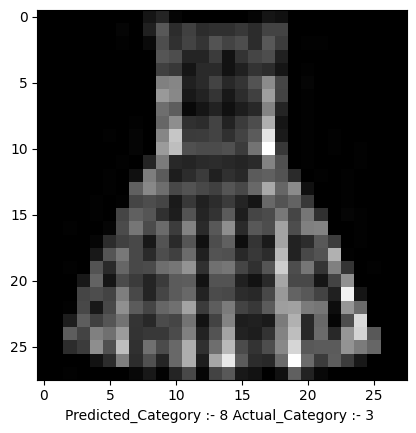

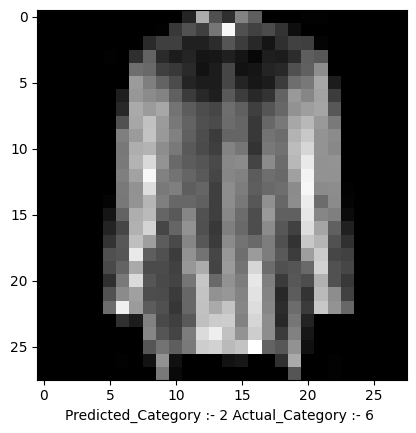

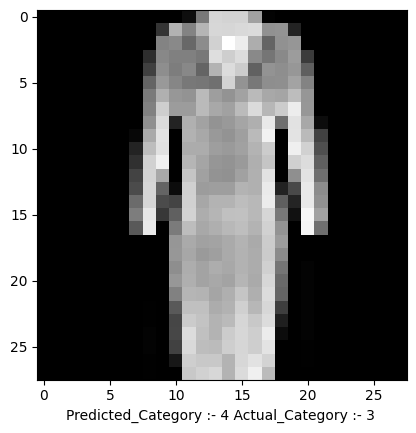

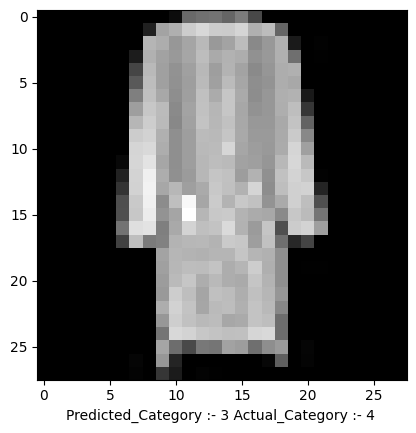

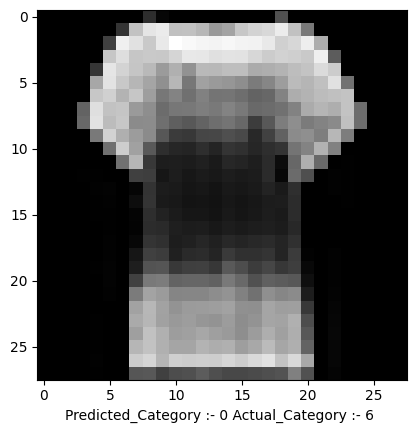

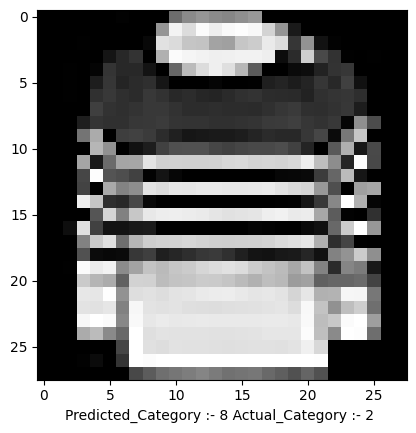

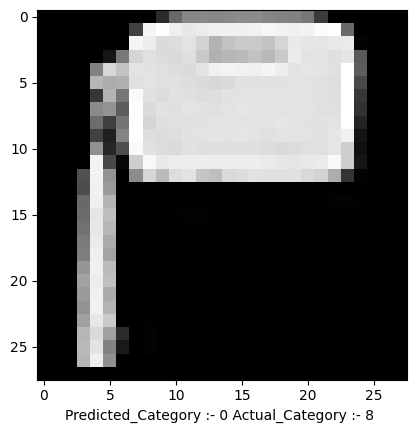

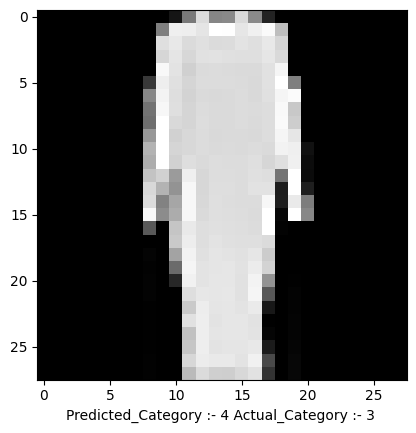

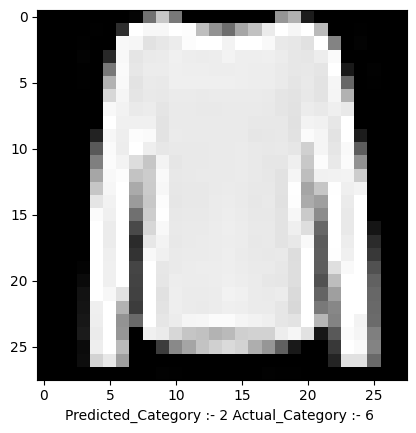

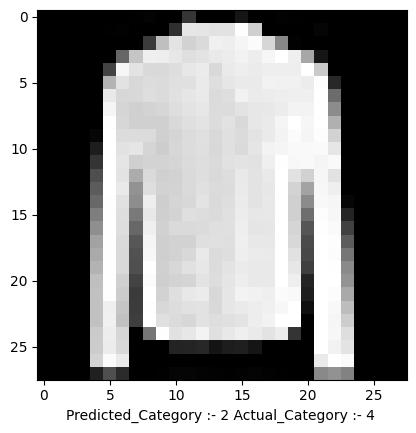

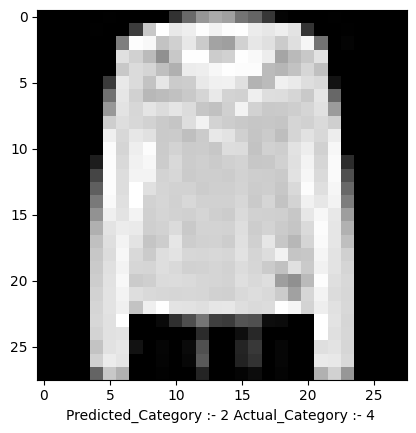

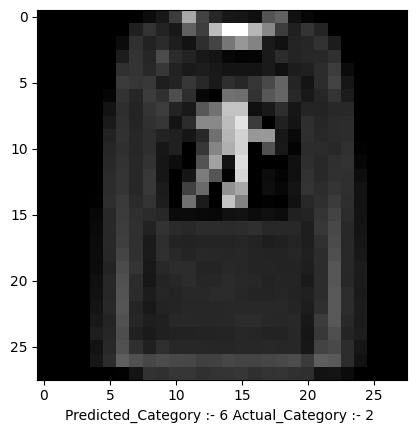

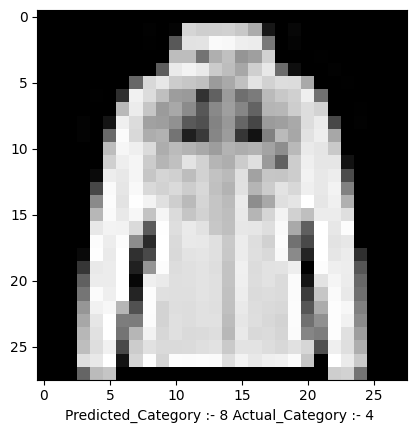

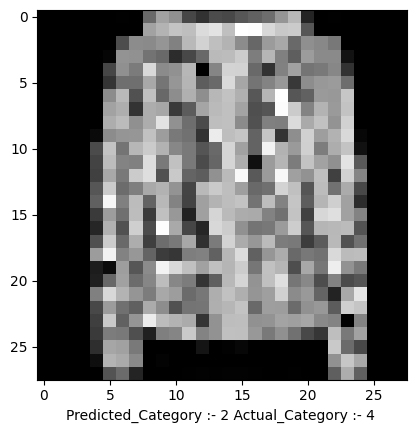

In [25]:
output1 = model.evaluate(X_CVS)
output1.shape
for i in range(X_CVS.shape[1]):
  if output1[0,i] != Y_CVS[i,0]:
    plt.imshow(X_CVS[i,:].reshape(28,28),cmap = "gray")
    plt.xlabel("Predicted_Category :- " + str(output1[0,i])+" Actual_Category :- "+ str(Y_CVS[i,0])+" ")
    plt.show()